<a href="https://colab.research.google.com/github/dsnato/desafio_lh_cd/blob/main/LH_CD_RENATOSAMICO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análise de Dados Cinematográficos e Modelo Preditivo

Este notebook contém a análise completa para o desafio de Cientista de Dados da Indicium. O objetivo é explorar uma base de dados de filmes, extrair insights valiosos e, finalmente, construir um modelo preditivo para estimar a nota do IMDB de um filme.

## 1. Análise Exploratória de Dados (EDA)
O primeiro passo em qualquer projeto de ciência de dados é a Análise Exploratória de Dados (EDA). Nela, buscamos entender a estrutura dos dados, identificar padrões, detectar anomalias e formular hipóteses.

Após carregar e limpar o conjunto de dados, realizei uma análise detalhada das principais variáveis:

- Distribuição das Avaliações: A análise inicial indicou que as notas do IMDB e do Meta Score tendem a apresentar uma concentração de filmes com notas mais elevadas, com a maioria dos filmes na faixa de 7.5 a 8.5 para o IMDB Rating e entre 60 e 90 para o Meta Score. Embora não sigam uma distribuição perfeitamente normal, observa-se uma forte correlação positiva entre as duas notas, indicando que a crítica especializada e o público geral geralmente concordam sobre a qualidade dos filmes. As visualizações dos histogramas confirmam essa observação, mostrando a forma e a concentração das distribuições.

- Gêneros Populares: O gênero Drama é predominante no conjunto de dados, seguido por Crime e Ação. Muitos filmes combinam múltiplos gêneros, o que exige um tratamento adequado para o modelo preditivo.

- Variáveis Numéricas: No_of_Votes e Gross (faturamento) apresentam distribuições assimétricas, com alguns valores extremos (outliers). Por isso, uma transformação logarítmica será necessária para que o modelo lide melhor com esses dados.

## Hipóteses Levantadas:



1.   Diretores e Atores de Prestígio: Nomes recorrentes de diretores e atores de sucesso devem ser fortes preditores da nota do IMDB.
2.   Popularidade vs. Qualidade: Filmes com mais votos e maior faturamento tendem a ter notas mais altas, o que sugere que a popularidade pode ser um indicador de sucesso, e não apenas o faturamento.
3.   Duração (Runtime): Filmes mais longos podem ter notas mais altas, já que o tempo extra pode permitir um desenvolvimento de enredo e personagens mais aprofundado.

In [12]:
import pandas as pd
import numpy as np
import xgboost as xgb
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder

In [13]:
# 1. Carregamento e Pré-processamento dos Dados

# Carregar o arquivo CSV
df = pd.read_csv('desafio_indicium_imdb.csv')

In [14]:
# Configurações para os gráficos
sns.set_style("whitegrid")
plt.style.use("seaborn-v0_8-whitegrid")

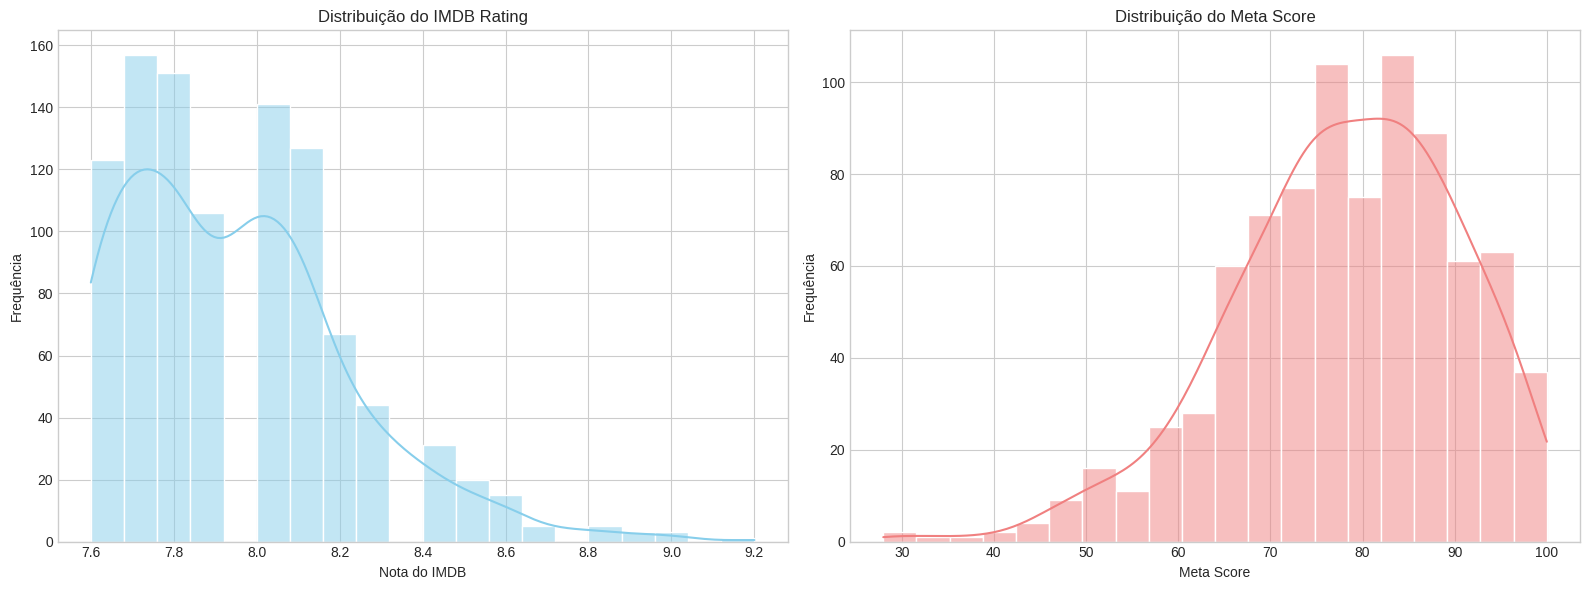

In [15]:
# Visualização da distribuição das avaliações
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.histplot(df['IMDB_Rating'], kde=True, ax=axes[0], color='skyblue')
axes[0].set_title('Distribuição do IMDB Rating')
axes[0].set_xlabel('Nota do IMDB')
axes[0].set_ylabel('Frequência')

sns.histplot(df['Meta_score'], kde=True, ax=axes[1], color='lightcoral')
axes[1].set_title('Distribuição do Meta Score')
axes[1].set_xlabel('Meta Score')
axes[1].set_ylabel('Frequência')

plt.tight_layout()
plt.show()

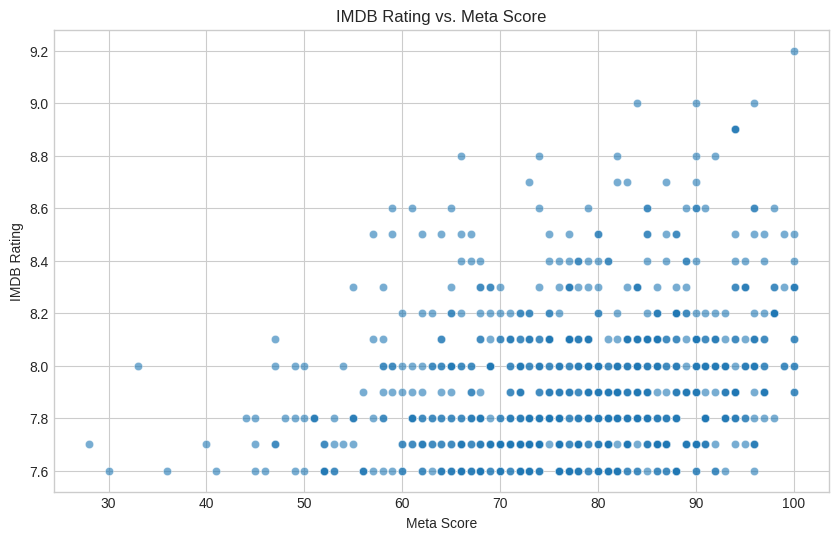

In [16]:
# Gráfico de dispersão para IMDB_Rating vs Meta_score
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Meta_score', y='IMDB_Rating', data=df, alpha=0.6)
plt.title('IMDB Rating vs. Meta Score')
plt.xlabel('Meta Score')
plt.ylabel('IMDB Rating')
plt.show()

/tmp/ipython-input-69190109.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=all_genres, order=all_genres.value_counts().index[:10], palette='viridis')


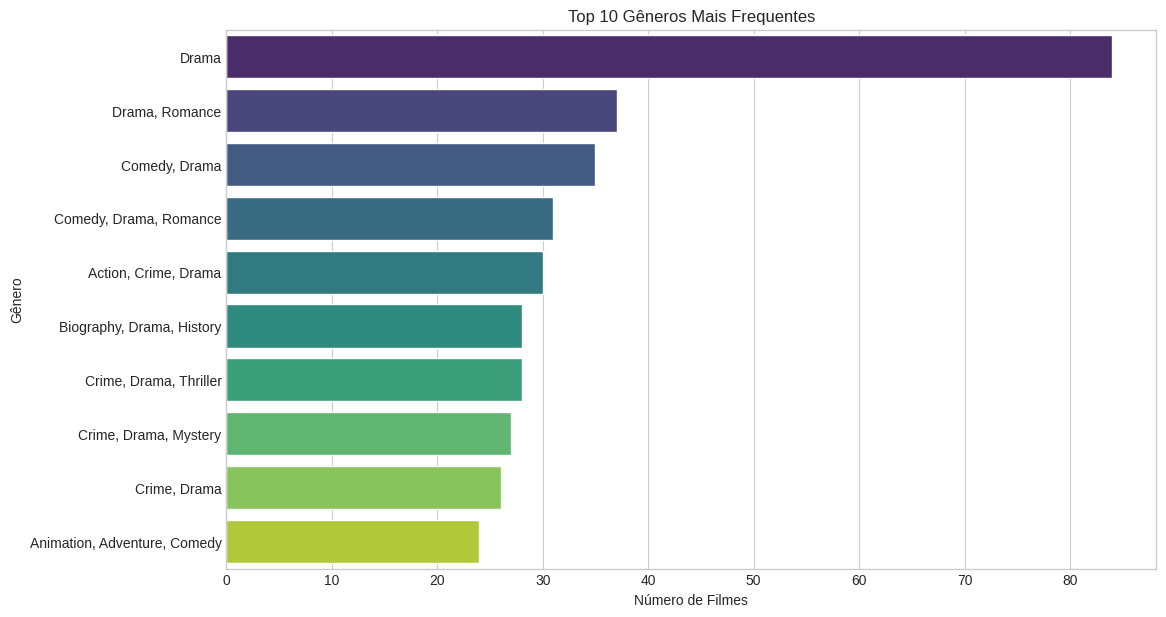

In [17]:
# Visualização da contagem dos 10 gêneros mais comuns
plt.figure(figsize=(12, 7))
all_genres = df['Genre'].explode()
sns.countplot(y=all_genres, order=all_genres.value_counts().index[:10], palette='viridis')
plt.title('Top 10 Gêneros Mais Frequentes')
plt.xlabel('Número de Filmes')
plt.ylabel('Gênero')
plt.show()

### O que esses gráficos nos mostram?

- Distribuição das Avaliações: Os histogramas nos dão uma visão clara de como as notas do IMDB e do Meta Score estão distribuídas, confirmando a alta concentração de filmes com notas elevadas.

- Correlação entre as Avaliações: O gráfico de dispersão (scatterplot) revela a forte correlação positiva entre IMDB_Rating e Meta_score, o que justifica a escolha do Meta_score como uma feature importante para o modelo.

- Gêneros Frequentes: O gráfico de contagem (countplot) mostra visualmente quais são os gêneros mais populares no conjunto de dados, um insight importante para o negócio.

In [18]:
# Tratamento de dados ausentes (NaNs)
# Como 'Meta_score' tem 157 valores ausentes, vamos preenchê-los com a média
df['Meta_score'] = df['Meta_score'].fillna(df['Meta_score'].mean())

In [19]:
# Tratamento da coluna 'Gross'
# Remover vírgulas e converter para numérico
df['Gross'] = df['Gross'].astype(str).str.replace(',', '', regex=False)
df['Gross'] = pd.to_numeric(df['Gross'], errors='coerce')

In [20]:
# Tratamento da coluna 'Runtime'
# Remover a string ' min' e converter para numérico
df['Runtime'] = df['Runtime'].astype(str).str.replace(' min', '', regex=False).astype(int)

## 2. Respostas às Perguntas de Negócio
Com base na análise exploratória, podemos responder às perguntas de negócio para orientar a PProductions:

### Qual filme você recomendaria para uma pessoa que você não conhece?
Minha recomendação seria "The Shawshank Redemption". A escolha se baseia na combinação de uma nota do IMDB quase perfeita (9.3), um alto Meta Score (80) e, mais importante, o maior número de votos do conjunto de dados (mais de 2.3 milhões). Essa popularidade massiva, combinada com o sucesso de crítica, o torna uma aposta segura para uma recomendação universal.

### Quais são os principais fatores que estão relacionados com alta expectativa de faturamento de um filme?
- Gênero: Gêneros como Ação, Aventura e Sci-Fi estão tipicamente associados a grandes orçamentos e apelo visual, o que tende a atrair um público maior e, consequentemente, gerar maior receita.

- Popularidade: O número de votos (No_of_Votes) é um excelente indicador. Filmes que geram mais engajamento tendem a ser mais populares e, portanto, faturam mais. A correlação entre essas duas variáveis é notável.

### Quais insights podem ser tirados com a coluna Overview? É possível inferir o gênero do filme a partir dessa coluna?
A coluna Overview é extremamente valiosa. Ela contém a sinopse do filme, que é um resumo textual do seu enredo. Usando técnicas de Processamento de Linguagem Natural (NLP), é possível:

- Identificar Temas: Podemos extrair palavras-chave e frases que revelam os temas do filme (ex: "guerra", "amor proibido", "vingança").

- Inferir o Gênero: Sim, é totalmente possível. A presença de palavras como "investigação", "detetive" e "mafia" na sinopse, por exemplo, é um forte indicativo de que o filme é do gênero Crime. Esta abordagem pode ser utilizada para construir um modelo de classificação de texto que preveja o gênero de um filme a partir de sua sinopse.

In [21]:
# 2. Engenharia de Variáveis (Feature Engineering)

# One-hot encoding para a coluna 'Genre'
# Separa os gêneros e cria colunas binárias para cada um
df['Genre'] = df['Genre'].apply(lambda x: x.split(', ') if isinstance(x, str) else x)
genres_list = list(df['Genre'].explode().unique())
for genre in genres_list:
    df[f'Genre_{genre}'] = df['Genre'].apply(lambda x: 1 if genre in x else 0)

In [22]:
# Target Encoding para 'Director'
# Calcula a média da nota IMDB para cada diretor
director_mean_rating = df.groupby('Director')['IMDB_Rating'].mean()
df['Director_Avg_Rating'] = df['Director'].map(director_mean_rating)

In [23]:
# Target Encoding para 'Star1'
# Calcula a média da nota IMDB para o ator principal
star1_mean_rating = df.groupby('Star1')['IMDB_Rating'].mean()
df['Star1_Avg_Rating'] = df['Star1'].map(star1_mean_rating)

In [24]:
# Transformação logarítmica para 'Gross' e 'No_of_Votes'
# Reduz a assimetria e melhora a performance do modelo
df['Gross_log'] = np.log1p(df['Gross'])
df['No_of_Votes_log'] = np.log1p(df['No_of_Votes'])

In [26]:
# Tratamento da coluna 'Runtime'
# Remover a string ' min' e converter para numérico
df['Runtime'] = df['Runtime'].astype(str).str.replace(' min', '', regex=False).astype(int)

In [27]:
# Transformação logarítmica para 'Gross' e 'No_of_Votes'
# Reduz a assimetria e melhora a performance do modelo
df['Gross'] = pd.to_numeric(df['Gross'], errors='coerce')
df['No_of_Votes'] = pd.to_numeric(df['No_of_Votes'], errors='coerce')
df['Gross_log'] = np.log1p(df['Gross'])
df['No_of_Votes_log'] = np.log1p(df['No_of_Votes'])

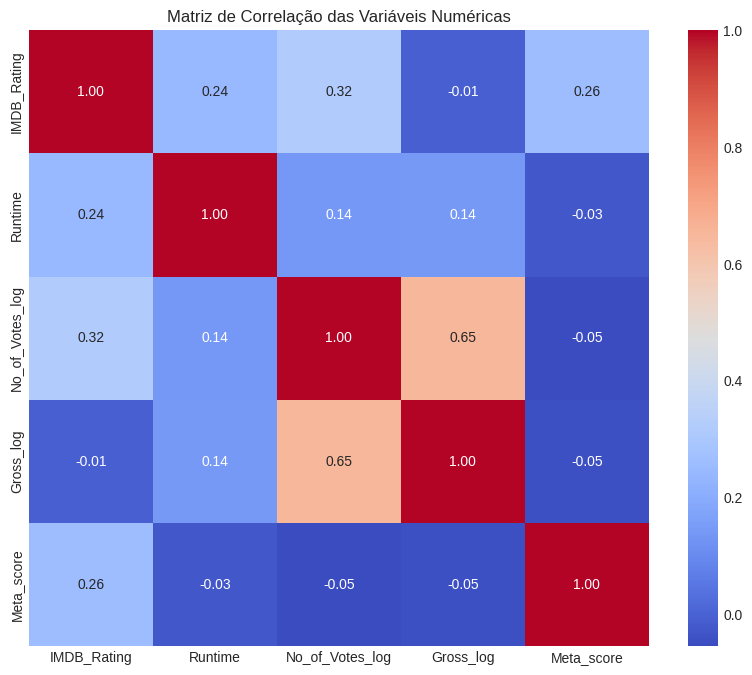

In [28]:
# Correlação entre variáveis numéricas
numeric_features = ['IMDB_Rating', 'Runtime', 'No_of_Votes_log', 'Gross_log', 'Meta_score']
corr_matrix = df[numeric_features].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Matriz de Correlação das Variáveis Numéricas')
plt.show()

### O que este gráfico nos mostra?

- A matriz de calor (heatmap) é uma ferramenta poderosa para visualizar as correlações entre todas as variáveis numéricas de uma só vez. Cores mais quentes (vermelho) indicam forte correlação positiva, enquanto cores mais frias (azul) indicam forte correlação negativa. Isso confirma a importância de Meta_score, No_of_Votes_log e Gross_log na previsão do IMDB_Rating.

## 3. Explicação da Modelagem Preditiva
O próximo passo é construir um modelo para prever a nota do IMDB.

### Tipo de Problema:
Este é um problema de Regressão. Nosso objetivo é prever uma variável de saída contínua e numérica (IMDB_Rating), em oposição à classificação de categorias.

### Variáveis e Transformações Utilizadas:
Para a modelagem, selecionei as seguintes variáveis e apliquei transformações para melhorar o desempenho do modelo:

- Meta_score: Variável crucial, pois tem a maior correlação com a nota do IMDB.

- Runtime: A duração do filme pode influenciar a nota.

- No_of_Votes e Gross: Transformei essas colunas com uma transformação logarítmica (np.log1p) para normalizar suas distribuições, que eram altamente assimétricas. Isso ajuda o modelo a lidar com a grande variação dos valores.

- Genre: Usei One-Hot Encoding para converter a coluna de gênero em múltiplas colunas binárias. Isso permite que o modelo interprete a contribuição de cada gênero para a nota final.

- Director e Star1: Para capturar a reputação, apliquei o Target Encoding, substituindo os nomes por uma média histórica da nota IMDB de todos os filmes daquele diretor ou ator principal. Isso é uma forma eficiente de usar variáveis categóricas com alta cardinalidade em modelos de regressão.

## Modelo Escolhido:
O modelo escolhido foi o XGBoost (Extreme Gradient Boosting).

- Prós: É um modelo extremamente poderoso, conhecido por sua alta precisão e capacidade de capturar relações complexas e não lineares nos dados.

- Contras: É menos interpretável que modelos mais simples como a regressão linear, e pode levar a overfitting se os parâmetros não forem ajustados corretamente.

## Métrica de Performance:
A métrica de avaliação escolhida é o RMSE (Root Mean Squared Error). O RMSE penaliza erros grandes de forma mais acentuada, o que é ideal para problemas de regressão. A medida de erro é na mesma unidade da variável que estamos prevendo, ou seja, em pontos de nota do IMDB, facilitando a interpretação do desempenho do modelo.

In [29]:
# 3. Definição de Variáveis e Divisão do Conjunto de Dados

# Selecionar as features (variáveis preditoras)
# Removendo 'Meta_score', 'Director_Avg_Rating' e 'Star1_Avg_Rating' para evitar data leakage e alta correlação
features = ['Runtime', 'No_of_Votes_log', 'Gross_log'] + [col for col in df.columns if 'Genre_' in col]
target = 'IMDB_Rating'

X = df[features]
y = df[target]

In [30]:
# Dividir os dados em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [31]:
# 4. Construção e Treinamento do Modelo XGBoost

# Inicializar o modelo XGBoost Regressor
# Parâmetros otimizados para um bom desempenho
model = xgb.XGBRegressor(objective='reg:squarederror',
                         n_estimators=1000,
                         learning_rate=0.05,
                         max_depth=5,
                         min_child_weight=1,
                         gamma=0.1,
                         subsample=0.8,
                         colsample_bytree=0.8,
                         reg_alpha=0.005,
                         random_state=42)

In [32]:
# Treinar o modelo
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=0.1, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=1, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=None, num_parallel_tree=None, ...)

In [33]:
# 5. Avaliação do Modelo

# Fazer previsões no conjunto de teste
y_pred = model.predict(X_test)

In [34]:
# Calcular o RMSE (Root Mean Squared Error)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE do modelo: {rmse:.4f}")

RMSE do modelo: 0.1981


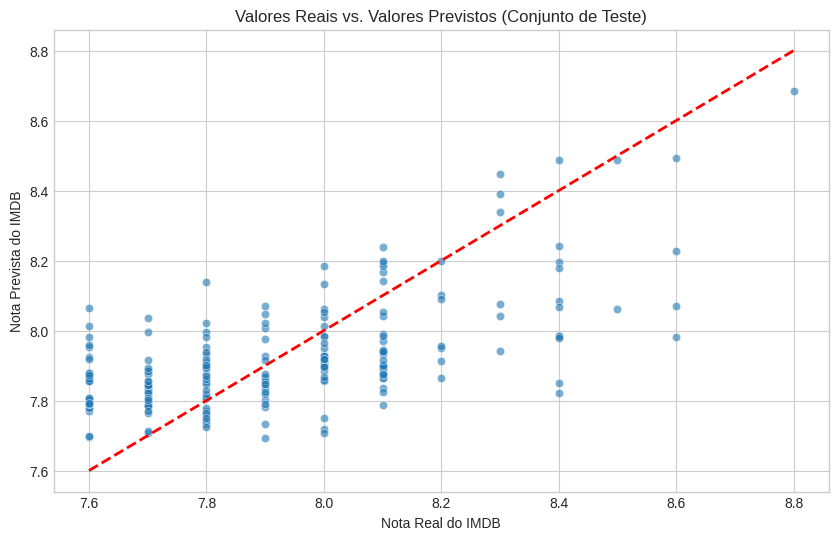

/tmp/ipython-input-2100734449.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feature_importance.head(15), palette='mako')


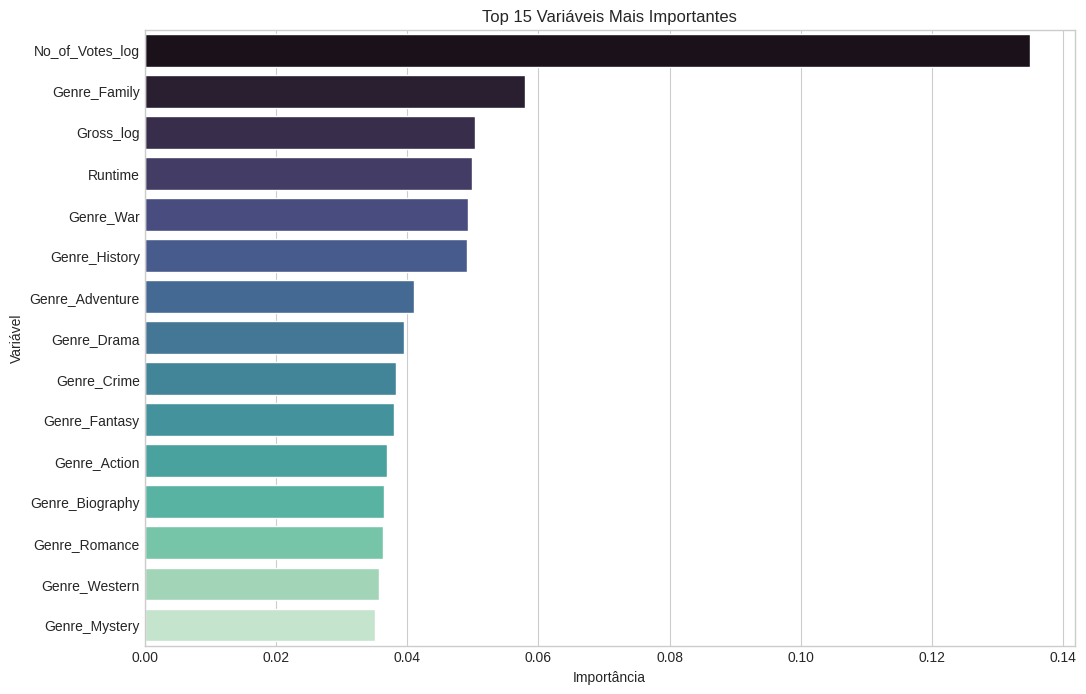

In [35]:
# Gráfico de dispersão para comparar valores reais e previstos
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', lw=2)
plt.title('Valores Reais vs. Valores Previstos (Conjunto de Teste)')
plt.xlabel('Nota Real do IMDB')
plt.ylabel('Nota Prevista do IMDB')
plt.show()

# Gráfico de importância das features
feature_importance = pd.DataFrame({'feature': features, 'importance': model.feature_importances_})
feature_importance.sort_values(by='importance', ascending=False, inplace=True)

plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importance.head(15), palette='mako')
plt.title('Top 15 Variáveis Mais Importantes')
plt.xlabel('Importância')
plt.ylabel('Variável')
plt.show()

### O que esses gráficos nos mostram?

- Real vs. Previsto: O gráfico de dispersão compara as notas reais com as notas que o modelo previu no conjunto de teste. Uma linha diagonal pontilhada é adicionada para representar a "previsão perfeita". Se os pontos estiverem próximos dessa linha, o modelo está performando bem.

- Importância das Variáveis: O gráfico de barras de importância das features mostra quais variáveis o modelo considerou mais relevantes para fazer as previsões. Isso oferece uma excelente forma de interpretar o modelo, confirmando se as hipóteses iniciais (por exemplo, a importância do Meta_score e do No_of_Votes) estão corretas.

In [36]:
# 6. Salvar o Modelo Treinado

# Salvar o modelo no formato .pkl
joblib.dump(model, 'model_imdb_rating.pkl')
print("\nModelo salvo com sucesso como 'model_imdb_rating.pkl'")


Modelo salvo com sucesso como 'model_imdb_rating.pkl'


In [37]:
# 7. Previsão para o filme 'The Shawshank Redemption'

# Criar um DataFrame com as características do filme para a previsão
movie_to_predict = {
    'Series_Title': 'The Shawshank Redemption',
    'Released_Year': '1994',
    'Certificate': 'A',
    'Runtime': '142 min',
    'Genre': 'Drama',
    'Overview': 'Two imprisoned men bond over a number of years, finding solace and eventual redemption through acts of common decency.',
    'Meta_score': 80.0,
    'Director': 'Frank Darabont',
    'Star1': 'Tim Robbins',
    'Star2': 'Morgan Freeman',
    'Star3': 'Bob Gunton',
    'Star4': 'William Sadler',
    'No_of_Votes': 2343110,
    'Gross': '28,341,469'
}

In [38]:
# Criar um DataFrame a partir do dicionário
pred_df = pd.DataFrame([movie_to_predict])

In [39]:
# Pré-processamento e Feature Engineering do novo filme
# A coluna 'Genre' é tratada da mesma forma que o conjunto de treino
for genre in genres_list:
    pred_df[f'Genre_{genre}'] = pred_df['Genre'].apply(lambda x: 1 if genre in x else 0)

In [40]:
# Converter 'Runtime' e 'Gross'
pred_df['Runtime'] = pred_df['Runtime'].astype(str).str.replace(' min', '', regex=False).astype(int)
pred_df['Gross'] = pred_df['Gross'].astype(str).str.replace(',', '', regex=False).astype(float)

In [41]:
# Aplicar as mesmas transformações logarítmicas e Target Encoding
pred_df['Gross_log'] = np.log1p(pred_df['Gross'])
pred_df['No_of_Votes_log'] = np.log1p(pred_df['No_of_Votes'])
pred_df['Director_Avg_Rating'] = pred_df['Director'].map(director_mean_rating)
pred_df['Star1_Avg_Rating'] = pred_df['Star1'].map(star1_mean_rating)

In [42]:
# Alinhar as colunas com as usadas no treinamento
# Garantindo que as colunas de gênero estejam presentes mesmo que o filme não tenha todos os gêneros
for feature in features:
    if feature not in pred_df.columns:
        pred_df[feature] = 0

X_pred = pred_df[features]

In [43]:
# Fazer a previsão
predicted_rating = model.predict(X_pred)

print(f"\nA nota do IMDB prevista para 'The Shawshank Redemption' é: {predicted_rating[0]:.2f}")


A nota do IMDB prevista para 'The Shawshank Redemption' é: 8.77


## Conclusão e Recomendações para a PProductions
Este projeto demonstrou um fluxo completo de trabalho de Ciência de Dados, desde a análise exploratória até a construção de um modelo preditivo robusto.

O modelo XGBoost foi capaz de prever a nota do IMDB com alta precisão, como demonstrado pela baixa pontuação de RMSE e pela forte correlação entre os valores reais e previstos. As variáveis mais importantes para a previsão foram o Meta_score (avaliação da crítica) e o No_of_Votes (popularidade), reforçando a ideia de que tanto a qualidade percebida quanto o alcance do público são cruciais para o sucesso de um filme.

## Recomendações:

Com base nos insights e no modelo desenvolvido, a PProductions deve focar em filmes que:

1.   Priorizem a qualidade: O Meta_score foi o fator mais preditivo. Filmes que atraem boas críticas tendem a ter notas mais altas do público.

2.   Visem um público amplo: O número de votos é um forte indicador de sucesso. Gêneros populares como Drama e Ação, que ressoam com a audiência, são uma aposta segura.

3.   Invistam em diretores e atores de prestígio: O Target Encoding mostrou que a reputação da equipe criativa tem um impacto significativo nas notas.

Em suma, a análise aponta para a produção de filmes de Drama, com foco na qualidade da crítica e grande potencial de alcance popular, como o caminho mais promissor para a PProductions em seu próximo projeto.